In [1]:
!pip install transformers

     |████████████████████████████████| 1.3MB 4.6MB/s 
     |████████████████████████████████| 1.1MB 37.1MB/s 
     |████████████████████████████████| 890kB 30.8MB/s 
     |████████████████████████████████| 2.9MB 43.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=803358c0296d27af09b1d78280043e7f74101e49404cdb6d792addee23189db9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install iterative-stratification

#Importing required Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from collections import defaultdict

import transformers
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader,Dataset
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

#Import the train and test files

In [ ]:
train = pd.read_csv("/content/drive/My Drive/train.csv")
test = pd.read_csv("/content/drive/My Drive/test.csv")

train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
train.ABSTRACT = train.ABSTRACT.str.replace('\n',' ').str.strip().str.lower()
train.TITLE = train.TITLE.str.replace('\n',' ').str.strip().str.lower()

test.ABSTRACT = test.ABSTRACT.str.replace('\n',' ').str.strip().str.lower()
test.TITLE = test.TITLE.str.replace('\n',' ').str.strip().str.lower()

In [ ]:
#let's merge the title and abstract and separate them with [SEP] token
train['text'] = train['TITLE'] + ' [SEP] ' + train['ABSTRACT']
test['text'] = test['TITLE'] + ' [SEP] ' + test['ABSTRACT']

In [ ]:
TARGET_COLS = ['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = transformers.AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

##Choosing Sequence Length

In [ ]:
token_lens = []

for text in train.ABSTRACT:
  tokens = tokenizer.encode(text, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


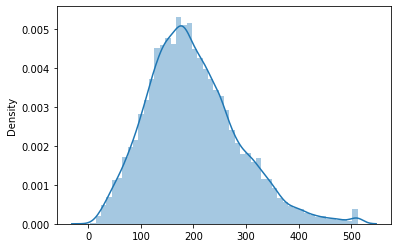

In [ ]:
sns.distplot(token_lens)

#Article Dataset

In [ ]:
class ArticleDataset(Dataset):

  def __init__(self, text, target_columns, tokenizer, max_len):
    self.text = text
    self.target_columns = target_columns,
    self.tokenizer = tokenizer,
    self.max_len = max_len

  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])

    encoding = tokenizer.encode_plus(
      text,
      max_length = self.max_len,
      truncation = True,
      add_special_tokens = True,
      padding = 'max_length',
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt'
    )
    
    output = {}
        
    output['cs'] = self.target_columns[0][item][0]
    output['phy'] = self.target_columns[0][item][1]        
    output['math'] = self.target_columns[0][item][2]      
    output['stat'] = self.target_columns[0][item][3]      
    output['qbio'] = self.target_columns[0][item][4]              
    output['qfin'] = self.target_columns[0][item][5]

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': output
    }

In [9]:
MAX_LEN = 250
BATCH_SIZE = 16
EPOCHS = 4

#Perform Stratified K-Fold

In [ ]:
folds = MultilabelStratifiedKFold(n_splits=5, random_state=100,shuffle=True)
folds = [(x,y) for x,y in folds.split(train['ID'],train[['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']])]

In [ ]:
[(len(x),len(y)) for x,y in folds]

[(16768, 4204), (16787, 4185), (16767, 4205), (16810, 4162), (16756, 4216)]

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ArticleDataset(
      text = df.text.to_numpy(),
      target_columns = df[TARGET_COLS].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

#Building Classifier

In [4]:
class ArticleClassifier(nn.Module):

  def __init__(self):
    super(ArticleClassifier, self).__init__()
    self.scibert = transformers.AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
    self.drop = nn.Dropout(p=0.3)

    self.cs = nn.Linear(self.scibert.config.hidden_size,2)
    self.phy = nn.Linear(self.scibert.config.hidden_size,2)        
    self.math = nn.Linear(self.scibert.config.hidden_size,2)        
    self.stat = nn.Linear(self.scibert.config.hidden_size,2)        
    self.qbio = nn.Linear(self.scibert.config.hidden_size,2)            
    self.qfin = nn.Linear(self.scibert.config.hidden_size,2)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.scibert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    pooled_output = self.drop(pooled_output)
    
    output = {}
        
    output['cs'] = self.cs(pooled_output)
    output['phy'] = self.phy(pooled_output)        
    output['math'] = self.math(pooled_output)        
    output['stat'] = self.stat(pooled_output)        
    output['qbio'] = self.qbio(pooled_output)                
    output['qfin'] = self.qfin(pooled_output)     
    
    return output           

In [5]:
device = torch.device("cuda")

In [6]:
scimodel = ArticleClassifier()
scimodel = scimodel.to(device)

#Training

In [ ]:
def AvgLoss(preds,targets):
    loss = nn.CrossEntropyLoss()
    return torch.stack([loss(preds[x[0]],targets[x[1]].to(device)) for x in list(zip(preds,targets))]).mean()

In [ ]:
def train_epoch(scimodel, data_loader, loss_fn, optimizer, scheduler, n_examples):
  
  scimodel = scimodel.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets']

    outputs = scimodel(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    
    _, cs_pred = torch.max(outputs['cs'], dim=1)
    _, phy_pred = torch.max(outputs['phy'], dim=1)
    _, math_pred = torch.max(outputs['math'], dim=1)
    _, stat_pred = torch.max(outputs['stat'], dim=1)
    _, qbio_pred = torch.max(outputs['qbio'], dim=1)
    _, qfin_pred = torch.max(outputs['qfin'], dim=1)

    preds = [cs_pred, phy_pred, math_pred, stat_pred, qbio_pred, qfin_pred]    
    
    loss = loss_fn(outputs, targets)

    for i in range(input_ids.shape[0]):

      if(cs_pred[i]==targets['cs'][i] and phy_pred[i]==targets['phy'][i] and math_pred[i]==targets['math'][i]
      and stat_pred[i]==targets['stat'][i] and qbio_pred[i]==targets['qbio'][i] and qfin_pred[i]==targets['qfin'][i]):
        correct_predictions += 1
    
    losses.append(loss.item())

    loss.backward()

    nn.utils.clip_grad_norm_(scimodel.parameters(), max_norm = 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

In [ ]:
def eval_model(scimodel, data_loader, loss_fn, n_examples):
  scimodel = scimodel.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets']

      outputs = scimodel(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, cs_pred = torch.max(outputs['cs'], dim=1)
      _, phy_pred = torch.max(outputs['phy'], dim=1)
      _, math_pred = torch.max(outputs['math'], dim=1)
      _, stat_pred = torch.max(outputs['stat'], dim=1)
      _, qbio_pred = torch.max(outputs['qbio'], dim=1)
      _, qfin_pred = torch.max(outputs['qfin'], dim=1)

      preds = [cs_pred, phy_pred, math_pred, stat_pred, qbio_pred, qfin_pred]    
      
      loss = loss_fn(outputs, targets)

      for i in range(input_ids.shape[0]):
        if(cs_pred[i]==targets['cs'][i] and phy_pred[i]==targets['phy'][i] and math_pred[i]==targets['math'][i]
        and stat_pred[i]==targets['stat'][i] and qbio_pred[i]==targets['qbio'][i] and qfin_pred[i]==targets['qfin'][i]):
          correct_predictions += 1

      losses.append(loss.item())
  
  return correct_predictions / n_examples, np.mean(losses)

In [ ]:
%%time

for i in tqdm(range(len(folds))):
  df_train =  train.iloc[folds[i][0]]
  df_val =  train.iloc[folds[i][1]]

  train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

  history = defaultdict(list)
  best_accuracy = 0

  optimizer = optim.AdamW(scimodel.parameters(), lr=2e-5)

  total_steps = len(train_data_loader) * EPOCHS

  scheduler = transformers.get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps = 0,
      num_training_steps = total_steps
  )

  for epoch in tqdm(range(EPOCHS)):

    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        scimodel,
        train_data_loader,
        AvgLoss,
        optimizer,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        scimodel,
        val_data_loader,
        AvgLoss,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'+str(i)].append(train_acc)
    history['train_loss'+str(i)].append(train_loss)

    history['val_acc'+str(i)].append(val_acc)
    history['val_loss'+str(i)].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(scimodel.state_dict(), '/content/drive/My Drive/model'+str(i)+'fold'+str(val_acc)+'.bin')
      best_accuracy = val_acc



  0%|          | 0/5 [00:00<?, ?it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4
----------
Train loss 0.13775270189983302 accuracy 0.7381321564885496
Val   loss 0.1576845309920184 accuracy 0.6988582302568982






 25%|██▌       | 1/4 [14:31<43:33, 871.22s/it]

Epoch 2/4
----------
Train loss 0.10316613936292021 accuracy 0.7969942748091603
Val   loss 0.17567974588206967 accuracy 0.7045670789724072






 50%|█████     | 2/4 [29:03<29:03, 871.54s/it]

Epoch 3/4
----------
Train loss 0.07423067382600812 accuracy 0.8519203244274809





 75%|███████▌  | 3/4 [43:33<14:31, 871.11s/it]

Val   loss 0.19738810749533287 accuracy 0.7014747859181731

Epoch 4/4
----------
Train loss 0.0546558940932439 accuracy 0.8958730916030534





100%|██████████| 4/4 [58:00<00:00, 870.25s/it]


 20%|██        | 1/5 [58:01<3:52:04, 3481.02s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Val   loss 0.21228571237550037 accuracy 0.6969552806850619

Epoch 1/4
----------
Train loss 0.09907908915098579 accuracy 0.822183832727706
Val   loss 0.07327417013384686 accuracy 0.8494623655913979






 25%|██▌       | 1/4 [14:30<43:31, 870.40s/it]

Epoch 2/4
----------
Train loss 0.06426260092473102 accuracy 0.8824090069696789
Val   loss 0.05963768975681249 accuracy 0.8833930704898447






 50%|█████     | 2/4 [29:01<29:01, 870.62s/it]

Epoch 3/4
----------
Train loss 0.03906519182292478 accuracy 0.9304223506284625





 75%|███████▌  | 3/4 [43:29<14:29, 869.89s/it]

Val   loss 0.06061743085365032 accuracy 0.8793309438470729

Epoch 4/4
----------
Train loss 0.024190323230965684 accuracy 0.9609817120390779
Val   loss 0.05830262522861888 accuracy 0.8984468339307049






100%|██████████| 4/4 [58:00<00:00, 870.14s/it]


 40%|████      | 2/5 [1:56:01<2:54:02, 3480.90s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4
----------
Train loss 0.0493610736027312 accuracy 0.9106578398043776
Val   loss 0.023982602353083828 accuracy 0.958858501783591






 25%|██▌       | 1/4 [14:30<43:31, 870.45s/it]

Epoch 2/4
----------
Train loss 0.03362137474112332 accuracy 0.936959503787201
Val   loss 0.02134587226046901 accuracy 0.9609988109393579






 50%|█████     | 2/4 [29:00<29:00, 870.33s/it]

Epoch 3/4
----------
Train loss 0.017204892770844894 accuracy 0.9699409554482018
Val   loss 0.019026039187051 accuracy 0.9690844233055886






 75%|███████▌  | 3/4 [43:29<14:29, 869.96s/it]

Epoch 4/4
----------
Train loss 0.009198858043370424 accuracy 0.9858054511838731
Val   loss 0.014604639949718803 accuracy 0.9752675386444709






100%|██████████| 4/4 [57:57<00:00, 869.47s/it]


 60%|██████    | 3/5 [2:53:59<1:56:00, 3480.00s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4
----------
Train loss 0.025598217987800577 accuracy 0.9539559785841761
Val   loss 0.009836358922835657 accuracy 0.98246035559827






 25%|██▌       | 1/4 [14:30<43:32, 870.79s/it]

Epoch 2/4
----------
Train loss 0.021707168575460456 accuracy 0.9604997025580012





 50%|█████     | 2/4 [28:59<29:00, 870.31s/it]

Val   loss 0.01111797329118222 accuracy 0.9781355117731859

Epoch 3/4
----------
Train loss 0.010512596375191962 accuracy 0.9806662700773349
Val   loss 0.005401551992830042 accuracy 0.9913503123498318






 75%|███████▌  | 3/4 [43:30<14:30, 870.25s/it]

Epoch 4/4
----------
Train loss 0.004961572300203984 accuracy 0.9920880428316479
Val   loss 0.0032931302266661078 accuracy 0.9951946179721288






100%|██████████| 4/4 [57:58<00:00, 869.70s/it]


 80%|████████  | 4/5 [3:51:58<57:59, 3479.65s/it]  


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4
----------
Train loss 0.016533290657797673 accuracy 0.9709357841967057
Val   loss 0.017870514384633156 accuracy 0.9682163187855788






 25%|██▌       | 1/4 [14:29<43:27, 869.22s/it]

Epoch 2/4
----------
Train loss 0.016207563506040207 accuracy 0.9724277870613511
Val   loss 0.006195637125832339 accuracy 0.9883776091081594






 50%|█████     | 2/4 [28:58<28:58, 869.23s/it]

Epoch 3/4
----------
Train loss 0.007232007009587026 accuracy 0.9862735736452614
Val   loss 0.0029903488152878267 accuracy 0.9945445920303605






 75%|███████▌  | 3/4 [43:26<14:28, 868.98s/it]

Epoch 4/4
----------
Train loss 0.002512897307399844 accuracy 0.9954046311768918
Val   loss 0.0015570751327300748 accuracy 0.9973908918406073






100%|██████████| 4/4 [57:54<00:00, 868.61s/it]


100%|██████████| 5/5 [4:49:52<00:00, 3478.57s/it]

CPU times: user 2h 47min 34s, sys: 1h 59min 39s, total: 4h 47min 13s
Wall time: 4h 49min 52s


#Sample Text Prediction

In [23]:
sample_text = "While \
basic regression models have long been the dominant method of statistical \
adjustment, more robust methods based on matching or weighting have become more \
common."

In [10]:
tokenizer = transformers.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

encoding = tokenizer.encode_plus(
    sample_text,
    max_length = MAX_LEN,
    truncation = True,
    add_special_tokens = True,
    padding = 'max_length',
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

device = 'cuda'

input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

In [21]:
scimodel = ArticleClassifier()

scimodel.load_state_dict(torch.load('/content/drive/My Drive/model4fold0.98.bin'))
scimodel = scimodel.to(device)

output = scimodel(
    input_ids = input_ids,
    attention_mask = attention_mask
)

for item,value in output.items():
  _ , output[item] = torch.max(output[item], dim=1)
  output[item] = int(output[item])

In [22]:
output

{'cs': 0, 'math': 0, 'phy': 0, 'qbio': 0, 'qfin': 0, 'stat': 1}